In [1]:
pip install alibi-detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 306 kB 14.9 MB/s 
     |████████████████████████████████| 4.7 MB 61.7 MB/s 
     |████████████████████████████████| 3.3 MB 60.7 MB/s 
     |████████████████████████████████| 34.5 MB 19 kB/s 
     |████████████████████████████████| 6.6 MB 53.8 MB/s 
     |████████████████████████████████| 120 kB 70.3 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.39.0
    Uninstalling llvmlite-0.39.0:
      Successfully uninstalled llvmlite-0.39.0
  Attempting uninstall: numba
    Found existing installation: numba 0.56.0
    Uninstalling numba-0.56.0:
      Successfully uninstalled numba-0.56.0


In [25]:
# !unzip /content/drive/MyDrive/Dataset.zip

In [26]:
# !unzip /content/drive/MyDrive/Models/Resnet152_2022.zip

Archive:  /content/drive/MyDrive/Models/Resnet152_2022.zip
   creating: content/saved_model/Resnet152_2022-08-31/
  inflating: content/saved_model/Resnet152_2022-08-31/keras_metadata.pb  
   creating: content/saved_model/Resnet152_2022-08-31/variables/
  inflating: content/saved_model/Resnet152_2022-08-31/variables/variables.data-00000-of-00001  
  inflating: content/saved_model/Resnet152_2022-08-31/variables/variables.index  
  inflating: content/saved_model/Resnet152_2022-08-31/saved_model.pb  
   creating: content/saved_model/Resnet152_2022-08-31/assets/


In [27]:
# !rm -rf /content/__MACOSX

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from alibi_detect.cd import ClassifierDrift
from alibi_detect.cd import KSDrift
from alibi_detect.models.tensorflow import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

In [3]:

train_dir='/content/Dataset/train'
valid_dir='/content/Dataset/val'
test_dir='/content/Dataset/test'

Size=224

In [15]:
import tensorflow as tf
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=1/255.0,
).flow_from_directory(train_dir,batch_size=16,target_size=(Size,Size),subset="training",shuffle=True)

valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
).flow_from_directory(valid_dir,batch_size=16,target_size=(Size,Size),shuffle=False)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
).flow_from_directory(test_dir,batch_size=16,target_size=(Size,Size),shuffle=False)


Found 42230 images belonging to 38 classes.
Found 9042 images belonging to 38 classes.
Found 9071 images belonging to 38 classes.


In [19]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)


In [22]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

16

In [8]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(8, 224, 224, 3) (8, 224, 224, 3)


In [9]:
new_model = tf.keras.models.load_model(f'/content/Resnet152_2022-08-31')
# Evaluate the restored model
loss, acc = new_model.evaluate(valid_generator)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
print(new_model.predict(valid_generator).shape)

566/566 [==============================] - 48s 65ms/step - loss: 0.1333 - accuracy: 0.9586
Restored model, accuracy: 95.86%
(9042, 38)


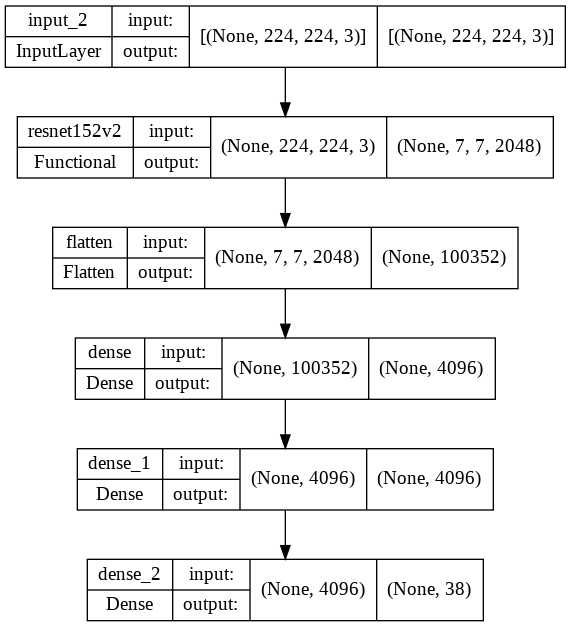

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(new_model, to_file='/tmp/model.png', show_shapes=True,)

In [12]:
cd = ClassifierDrift(X_ref, new_model, p_val=.05, preds_type='probs', n_folds=5, epochs=2)

In [13]:
preds = cd.predict(X_test)

In [14]:
preds

{'data': {'is_drift': 0,
  'distance': 0.1875,
  'p_val': 0.6646026831785345,
  'threshold': 0.05,
  'probs_ref': array([0.02631667, 0.0262976 , 0.0263121 , 0.02633244, 0.02629456,
         0.02631102, 0.02632137, 0.02632386], dtype=float32),
  'probs_test': array([0.02633141, 0.02633099, 0.02629821, 0.02633316, 0.02631604,
         0.0263103 , 0.02631407, 0.0263149 , 0.0263121 , 0.02631748,
         0.02632613, 0.02632101, 0.02632753, 0.02629456, 0.02631067,
         0.02629942], dtype=float32),
  'model': <keras.engine.functional.Functional at 0x7f78deaf3b10>},
 'meta': {'name': 'ClassifierDriftTF',
  'online': False,
  'data_type': None,
  'version': '0.10.3',
  'detector_type': 'drift',
  'params': {'binarize_preds ': False, 'preds_type': 'probs'},
  'backend': 'tensorflow'}}

##ChiSquareDrift

In [23]:
from alibi_detect.cd import ChiSquareDrift

cd = ChiSquareDrift(X_ref, p_val=0.05)

In [24]:
preds = cd.predict(X_test, drift_type='batch', return_p_val=True, return_distance=True)

In [25]:
preds

{'data': {'is_drift': 0,
  'distance': array([24., 24., 24., ..., 24., 24., 24.], dtype=float32),
  'p_val': array([0.40380844, 0.34722942, 0.29305854, ..., 0.24239217, 0.40380844,
         0.34722942], dtype=float32),
  'threshold': 3.3216411564625853e-07},
 'meta': {'name': 'ChiSquareDrift',
  'online': False,
  'data_type': None,
  'version': '0.10.3',
  'detector_type': 'drift'}}